In [4]:
library(tidyverse)
library(dplyr)
library(patchwork)
library(ggplot2)

In [5]:
#upload the dataset

diabetes <- read.csv("~/Downloads/diabetes 2.csv")

glimpse(diabetes)

Rows: 768
Columns: 9
$ Pregnancies              <int> 6, 1, 8, 1, 0, 5, 3, 10, 2, 8, 4, 10, 10, 1, …
$ Glucose                  <int> 148, 85, 183, 89, 137, 116, 78, 115, 197, 125…
$ BloodPressure            <int> 72, 66, 64, 66, 40, 74, 50, 0, 70, 96, 92, 74…
$ SkinThickness            <int> 35, 29, 0, 23, 35, 0, 32, 0, 45, 0, 0, 0, 0, …
$ Insulin                  <int> 0, 0, 0, 94, 168, 0, 88, 0, 543, 0, 0, 0, 0, …
$ BMI                      <dbl> 33.6, 26.6, 23.3, 28.1, 43.1, 25.6, 31.0, 35.…
$ DiabetesPedigreeFunction <dbl> 0.627, 0.351, 0.672, 0.167, 2.288, 0.201, 0.2…
$ Age                      <int> 50, 31, 32, 21, 33, 30, 26, 29, 53, 54, 30, 3…
$ Outcome                  <int> 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, …


The dataset comes from the National Institute of Diabetes and Digestive and Kidney Diseases and contains measurements from Pima Indian women aged 21+.

The goal: Predict the binary outcome "Outcome" (1 = diabetic).

Variables:
Pregnancies                  — number of pregnancies

Glucose                      — plasma glucose concentration

BloodPressure                — diastolic BP (mm Hg)

SkinThickness                — thickness of the skin (mm)

Insulin                      — serum insulin level in blood (mu U/ml)

BMI                          — body mass index

DiabetesPedigreeFunction     — genetic predisposition score (quantifies likelihood of having diabetes based on family history)

Age                          — age in years

Outcome                      — 1 = diabetic, 0 = non-diabetic

In [6]:
#Data Cleaning

#These variables contain physiologically impossible zeros. Replace zeros with NA.

cols_zero_na <- c("Glucose", "BloodPressure", "SkinThickness", 
                  "Insulin", "BMI")

diabetes <- diabetes %>% 
  mutate(across(all_of(cols_zero_na), ~na_if(., 0)))

# Keep only rows with full predictor information
diabetes <- diabetes %>% filter(complete.cases(.))

# Create a clean dataset for visualization
df_clean <- diabetes %>%
  mutate(Outcome = factor(Outcome, labels = c("Non-diabetic", "Diabetic")))

**Question 1**

Are glucose levels higher among participants who have diabetes?

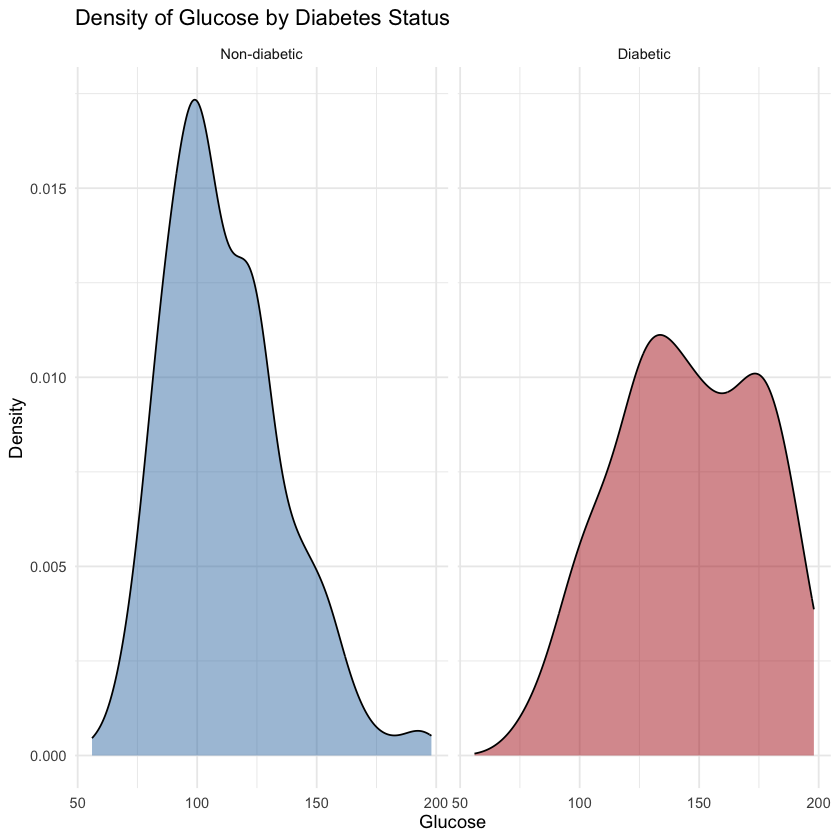

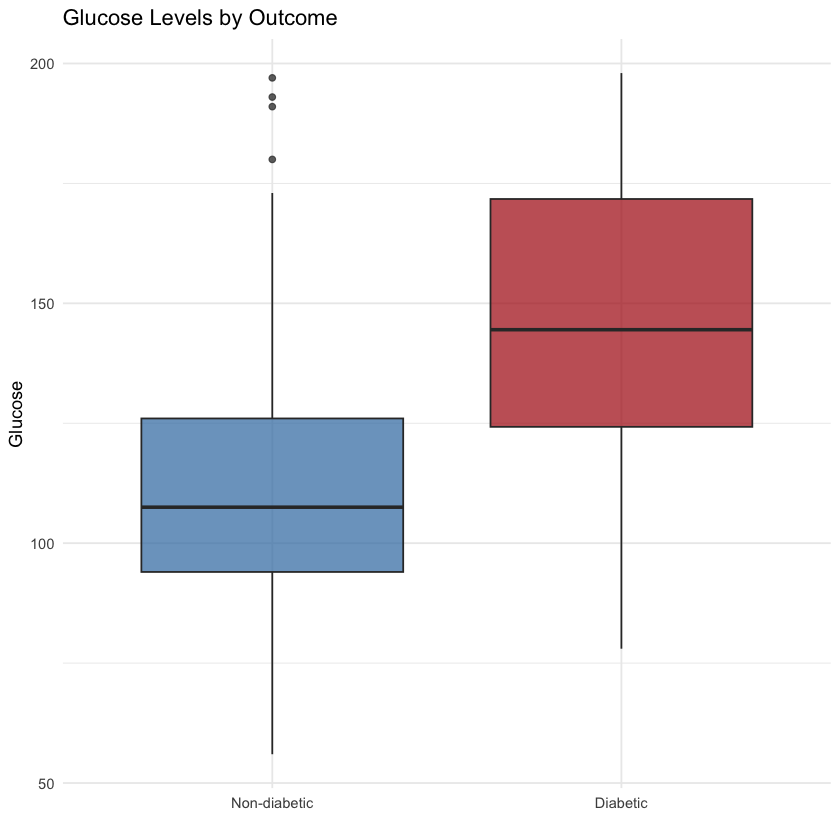

In [8]:
p1 <- ggplot(df_clean, aes(x = Glucose, fill = Outcome)) +
  geom_density(alpha = 0.5) +
  facet_wrap(~ Outcome, nrow = 1) +
  labs(title = "Density of Glucose by Diabetes Status",
       x = "Glucose", y = "Density") +
  scale_fill_manual(values = c("steelblue", "firebrick")) +
  theme_minimal() +
  theme(legend.position = "none")


p2 <- ggplot(df_clean, aes(x = Outcome, y = Glucose, fill = Outcome)) +
  geom_boxplot(alpha = 0.75) +
  scale_fill_manual(values = c("steelblue", "firebrick")) +
  labs(title = "Glucose Levels by Outcome", x = "", y = "Glucose") +
  theme_minimal() +
  theme(legend.position = "none")

p1
p2

The diabetic patient density plot appears to be bimodal and maybe has a slight skew left. It is wider compared to the non-diabetic density plot, which has many points around 100. From the boxplots, diabetic patients have higher glucose levels overall, with both the median and distribution shifted upward. These plots confirm what we know about diabetics tending to have greater glucose levels than non-diabetics.

**Question 2**

Does BMI differ between diabetic and non-diabetic individuals?

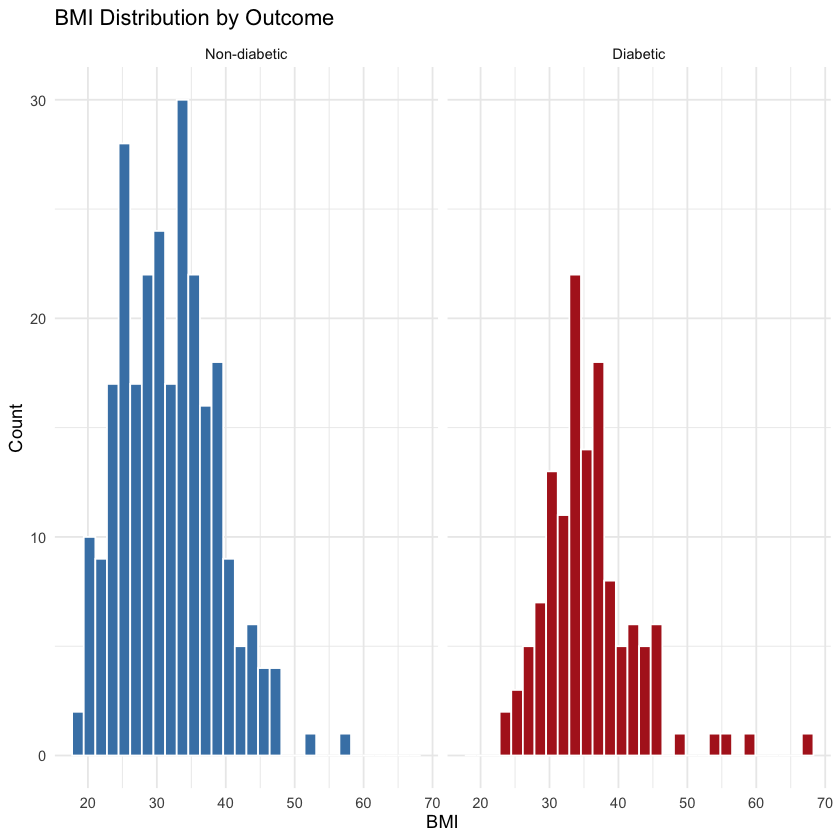

In [9]:
p3 <- ggplot(df_clean, aes(x = BMI, fill = Outcome)) +
  geom_histogram(bins = 30, color = "white") +
  facet_wrap(~ Outcome, nrow = 1) +
  labs(title = "BMI Distribution by Outcome", x = "BMI", y = "Count") +
  scale_fill_manual(values = c("steelblue", "firebrick")) +
  theme_minimal() +
  theme(legend.position = "none")

p3

BMI appears slightly greater in diabetic individuals, suggesting a potential risk factor but with more overlap than glucose. We know from research that BMI is not a good indicator of health, so it makes sense that there is some overlap. This dataset also does not distinguish which type of diabetes are being studied (type 1 vs. type 2).

**Question 3**

What do violin plots reveal about distribution shapes?

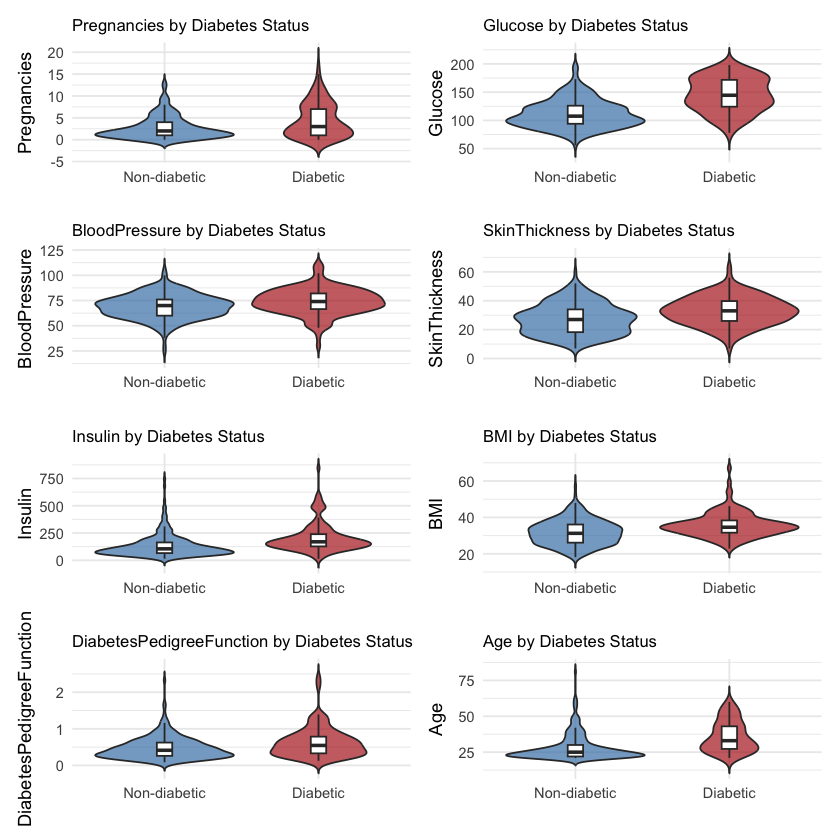

In [10]:
numeric_vars <- df_clean %>% select(where(is.numeric)) %>% names()

violin_list <- map(numeric_vars, function(v) {
  ggplot(df_clean, aes(x = Outcome, y = .data[[v]], fill = Outcome)) +
    geom_violin(trim = FALSE, alpha = 0.7) +
    geom_boxplot(width = 0.1, fill = "white", outlier.shape = NA) +
    scale_fill_manual(values = c("steelblue", "firebrick")) +
    labs(title = paste(v, "by Diabetes Status"), x = "", y = v) +
    theme_minimal() +
    theme(legend.position = "none",
          plot.title = element_text(size = 10))
})

wrap_plots(violin_list, ncol = 2)

The strongest predictors appear to be glucose, BMI, age, and pregnancies. Moderate predictors include DPF and insulin, and the weakest are blood pressure and skin thickness. It would be interesting to investigate the age and pregnancy variables a bit further to see how older age or more pregnancies impacts diabetes.

In [11]:
#Prepare Data for Modeling

# Scaling function
scale <- function(x){ (x - min(x)) / (max(x) - min(x)) }

df <- diabetes %>%
  transmute(
    has_diabetes     = 1 * (Outcome == 1),
    pregnancies      = scale(Pregnancies),
    glucose          = scale(Glucose),
    blood_pressure   = scale(BloodPressure),
    skin_thickness   = scale(SkinThickness),
    insulin          = scale(Insulin),
    bmi              = scale(BMI),
    pedigree         = scale(DiabetesPedigreeFunction),
    age              = scale(Age)
  )

**Question 4**

Using a logistic regression model, which variables are the most significant predictors of diabetes?

In [12]:
# logistic regression on the FULL dataset
logit_full <- glm(
  has_diabetes ~ pregnancies + glucose + blood_pressure + skin_thickness +
    insulin + bmi + pedigree + age,
  data = df,
  family = binomial()
)

summary(logit_full)


Call:
glm(formula = has_diabetes ~ pregnancies + glucose + blood_pressure + 
    skin_thickness + insulin + bmi + pedigree + age, family = binomial(), 
    data = df)

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -5.7710     0.7234  -7.977 1.49e-15 ***
pregnancies      1.3967     0.9422   1.482  0.13825    
glucose          5.4343     0.8190   6.635 3.24e-11 ***
blood_pressure  -0.1221     1.0177  -0.120  0.90446    
skin_thickness   0.6284     0.9567   0.657  0.51128    
insulin         -0.6867     1.0870  -0.632  0.52757    
bmi              3.4493     1.3370   2.580  0.00989 ** 
pedigree         2.6640     0.9981   2.669  0.00760 ** 
age              2.0371     1.1029   1.847  0.06474 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 498.10  on 391  degrees of freedom
Residual deviance: 344.02  on 383  degrees of freedom
AIC: 362.02

Number of 

Since I chose a dataset with a binary variable (Outcome), I wanted to do a logistic regression model to see which variables predict diabetes at a significant level. We see glucose as the most significant predictor, interestingly followed by pedigree and BMI. Insulin is not a significant predictor.

**Question 5**

What does a principal component analysis determine about these variables?

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
pregnancies,0.3778312,-0.59441845,0.30999548,-0.09658434,0.19887507,0.05977124,-0.59611472,0.002811838
glucose,0.5989416,0.10864332,-0.63124937,0.11028365,0.03532968,0.46377757,-0.01677909,-0.046988837
blood_pressure,0.2273506,0.01136963,0.19261123,0.43614973,-0.80365631,-0.05583566,-0.11030137,0.244354830
skin_thickness,0.3498930,0.50585709,0.50486547,-0.01713757,0.33503694,0.14693932,0.11139435,0.469309101
insulin,0.2890330,0.13100137,-0.32806770,-0.01594813,0.13631625,-0.84251961,-0.15351626,0.198562653
bmi,0.2306920,0.41662466,0.27178244,0.07412379,-0.03614077,-0.12811166,-0.16859583,-0.804799189
pedigree,0.1152702,0.14471899,-0.01498013,-0.88075570,-0.42454487,0.04100002,-0.07362411,0.049742419
age,0.4175559,-0.40885404,0.17810189,-0.08068091,-0.03099484,-0.16939919,0.74991887,-0.167990050


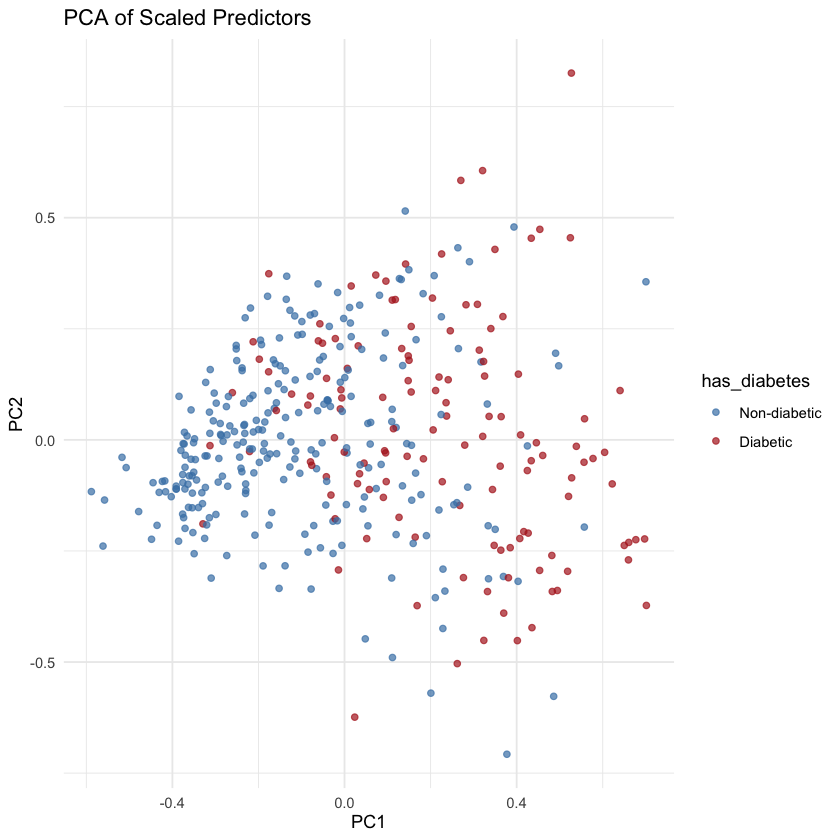

In [13]:
#PCA
df_pca_input <- df %>% select(-has_diabetes)

pca <- prcomp(df_pca_input, center = TRUE, scale. = FALSE)

pca_df <- as.data.frame(pca$x[, 1:2]) %>%
  rename(PC1 = PC1, PC2 = PC2) %>%
  mutate(has_diabetes = factor(df$has_diabetes,
                               labels = c("Non-diabetic", "Diabetic")))

ggplot(pca_df, aes(x = PC1, y = PC2, color = has_diabetes)) +
  geom_point(alpha = 0.7) +
  scale_color_manual(values = c("steelblue", "firebrick")) +
  labs(title = "PCA of Scaled Predictors",
       x = "PC1", y = "PC2") +
  theme_minimal()

pca$rotation

PCA showed that the first principal component (PC1) separates diabetic from non-diabetic patients, indicating that PC1 represents a metabolic axis strongly influenced by glucose, insulin, and BMI. Diabetic individuals tend to have higher PC1 scores.

PC2 did not separate the groups, suggesting that the variation represented by PC2 (likely age, pregnancies, or blood pressure differences) is not strongly related to diabetes status. However, it would be interesting to assess if there is a relationship in age, which would help distinguish between type 1 and type 2 diabetes. This was not a variable that was included in the dataset, since all observations were 21 and older. We know that young people with Type 1 diabetes tend to be adolescents or young adults, so it would be interesting if there is still a distinction with the given data.

Despite the information we are given from the PCA, logistic regression is definitely the preferred model for this data.

**Question 6**

Does clustering provide any further information about the distinction between people with and without diabetes?

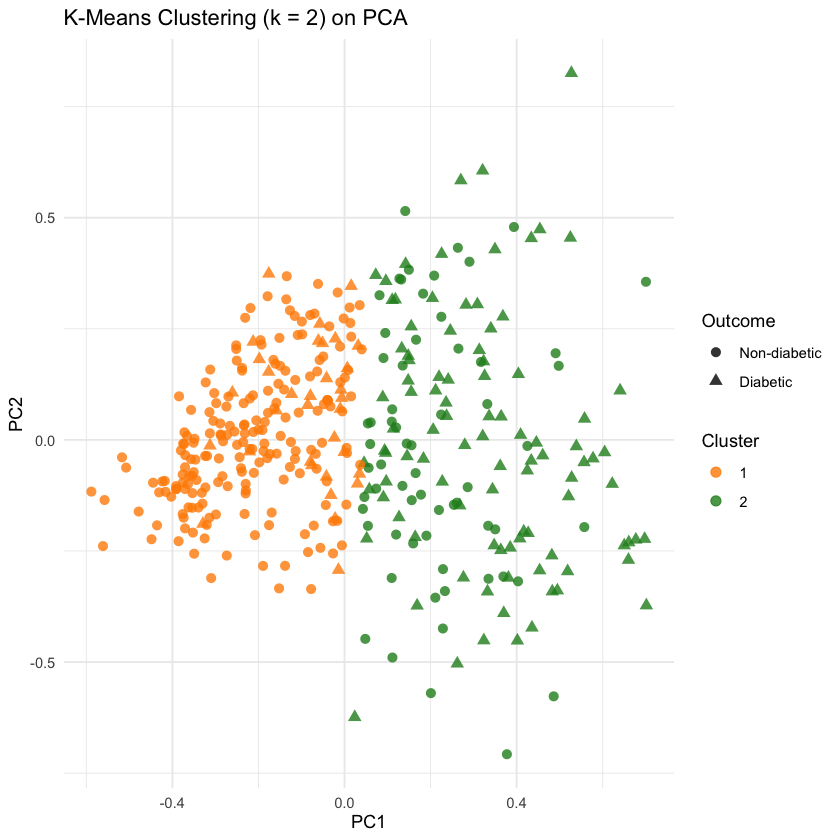

In [15]:
#kmeans clustering
set.seed(2025)
pca_scores <- pca_df %>% select(PC1, PC2)
kmeans_res <- kmeans(pca_scores, centers = 2, nstart = 25)

pca_df$cluster <- factor(kmeans_res$cluster)

ggplot(pca_df, aes(PC1, PC2, color = cluster, shape = has_diabetes)) +
  geom_point(alpha = 0.8, size = 2.5) +
  labs(title = "K-Means Clustering (k = 2) on PCA",
       x = "PC1", y = "PC2",
       color = "Cluster", shape = "Outcome") +
  scale_color_manual(values = c("darkorange", "forestgreen")) +
  theme_minimal()


Similar to PCA, clustering does not perfectly separate diabetic from non-diabetic patients, but the clusters follow PC1 patterns. This indicates that while there are metabolic patterns common to diabetic individuals, the dataset does not naturally fall into two perfectly distinct groups. This again emphasizes the need for logistic regression to provide more information on the data. It may be helpful to look into ROC curves or further investigate the odds ratios and confidence intervals for deeper insight to this data.